In [1]:
%load_ext autoreload
%autoreload 2

# Exploratory Analysis
- Pull daily ticker data for crypto assets (specify SYMBOL:CURRENCY Pair)
- Visualize data (line plots, candlestick charts etc.)

In [2]:
import os
import time
from tqdm.auto import tqdm
from pathlib import Path

os.chdir("..")

In [3]:
import pandas as pd
import mplfinance as mpf

from halvings import get_bitcoin_issuance
from get_ohlcv import get_top_cryptos, get_yahoo_ticker_data
from src.plots import *

plt.rcParams["figure.figsize"] = (24, 5)

In [4]:
btc_daily_issuance = get_bitcoin_issuance()
btc_daily_issuance

,Date,issuance
0,2012-12-31,7.200000e+03
1,2013-01-01,7.200000e+03
2,2013-01-02,7.200000e+03
3,2013-01-03,7.200000e+03
4,2013-01-04,7.200000e+03
...,...,...
70027,2204-08-23,5.115908e-11
70028,2204-08-24,5.115908e-11
70029,2204-08-25,5.115908e-11
70030,2204-08-26,5.115908e-11


# Load Data

In [6]:
dftop = get_top_cryptos()

topn = 100  # grab the largest topn by market cap
ticker_list = dftop.head(topn)["ticker"].tolist()
ticker_list[0:5]

['BTC-USD', 'ETH-USD', 'XRP-USD', 'USDT-USD', 'BNB-USD']

In [208]:
ticker = "BTC-USD"

DIR = Path("cache") / "ohlcv"
# list(DIR.glob("*"))
path_cache = DIR / f"{ticker}.snap.parquet"
df = pd.read_parquet(path_cache)
df["Date"] = df["Date"].dt.tz_convert(None)
df = df.merge(btc_daily_issuance, on="Date")
df

,Ticker,Date,Open,High,Low,Close,Volume,issuance
0,BTC-USD,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,7200.0
1,BTC-USD,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,7200.0
2,BTC-USD,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,7200.0
3,BTC-USD,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,7200.0
4,BTC-USD,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,7200.0
...,...,...,...,...,...,...,...,...
3802,BTC-USD,2025-02-11,97438.132812,98492.898438,94875.039062,95747.429688,37488783272,900.0
3803,BTC-USD,2025-02-12,95745.695312,98151.023438,94101.203125,97885.859375,49340445530,900.0
3804,BTC-USD,2025-02-13,97888.750000,98111.085938,95269.710938,96623.867188,37147280860,900.0
3805,BTC-USD,2025-02-14,96623.367188,98819.468750,96342.804688,97508.968750,32697987277,900.0


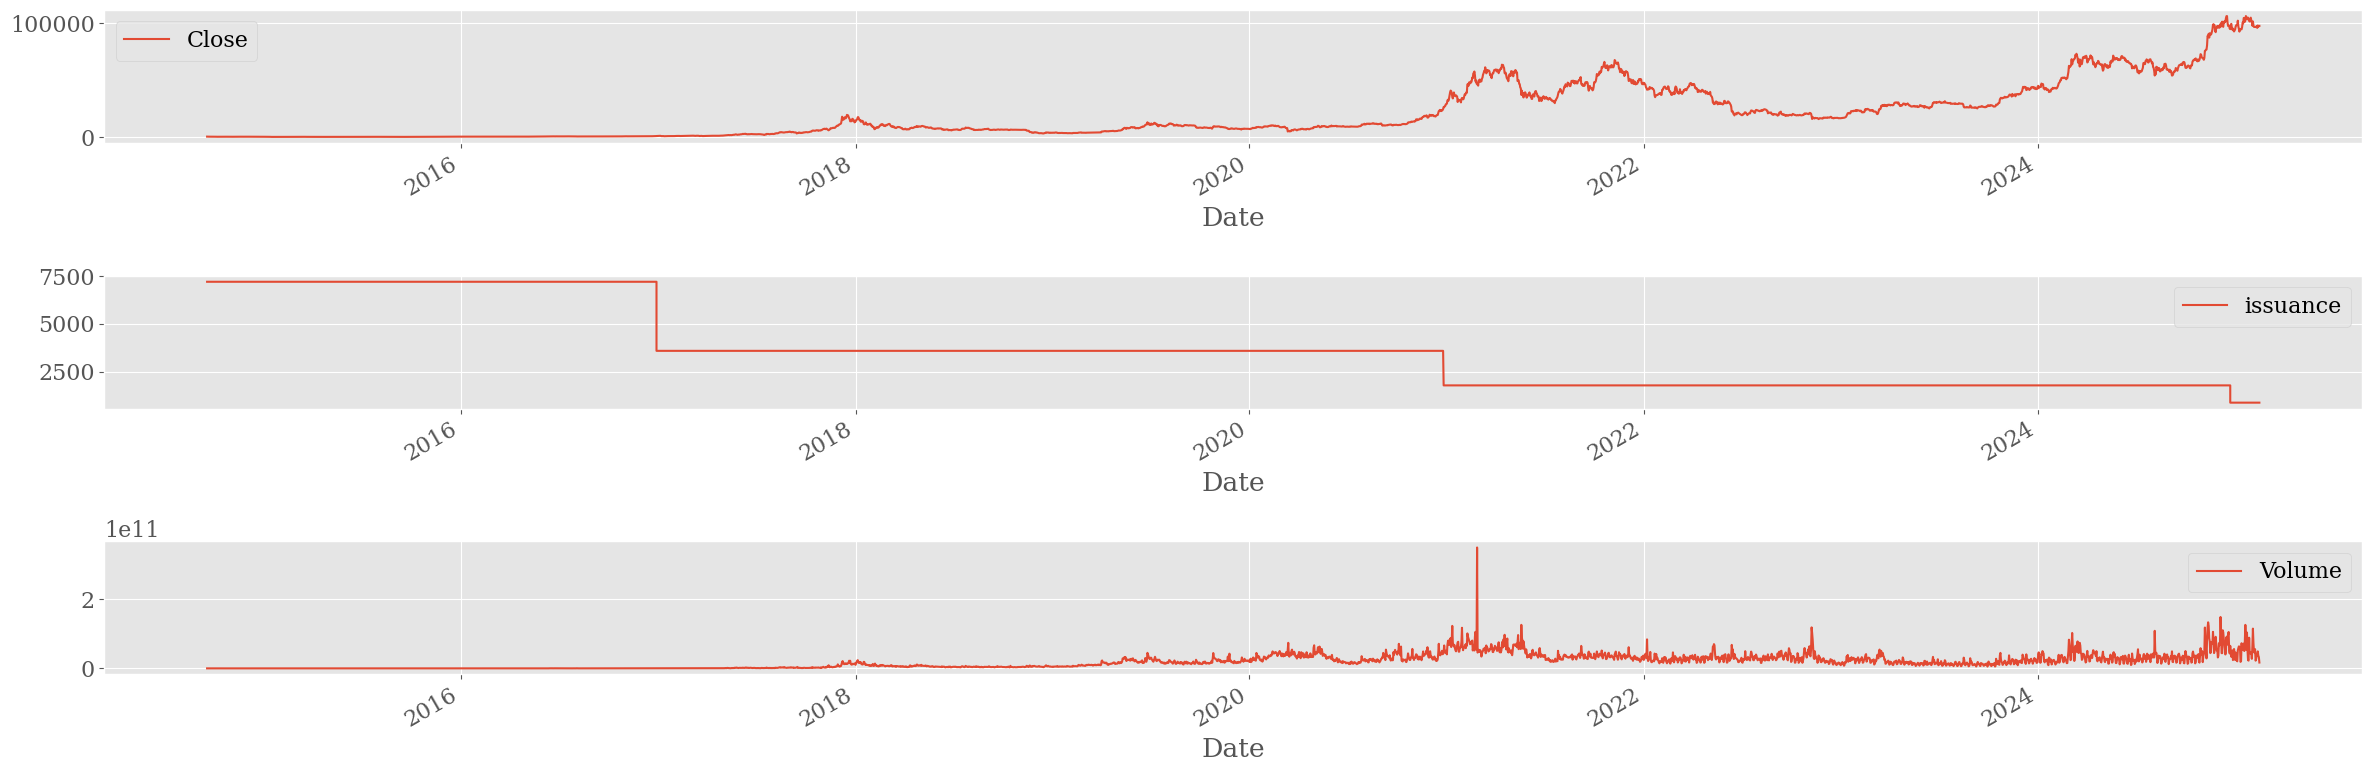

In [216]:
fig, ax = plt.subplots(3, 1, figsize=(24, 8))
df.plot(x="Date", y="Close", ax=ax[0])
df.plot(x="Date", y="issuance", ax=ax[1])
df.plot(x="Date", y="Volume", ax=ax[2])
plt.tight_layout()
plt.show()

# Choose Ticker for Analysis

In [9]:
ticker = ticker_list[0]

df = get_yahoo_ticker_data(ticker)

YFRateLimitError: Too Many Requests. Rate limited. Try after a while.

In [ ]:
fig, ax = plt.subplots()
df.set_index("Date")[["Open", "High", "Low", "Close"]].plot(ax=ax, title=f"{ticker}")
format_yaxis_thousands(ax)

In [ ]:
data = df.set_index("Date")[["Open", "High", "Low", "Close"]]
mpf.plot(data.tail(300), type="candle", style="charles", title=f"{ticker} OHLC", ylabel="Price (USD)", figsize=(25, 6))

In [ ]:
ohlcv_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

mpf.plot(df.set_index("Date")[ohlcv_cols], 
         # type="candle", 
         style="yahoo",  # Dark mode theme
         title=f"{ticker} Price Chart",
         ylabel="Price (USD)",
         ylabel_lower="Volume",
         volume=True,
         type="line",
         mav=(10, 50),       # 10-day & 50-day moving averages
         figratio=(25, 12),  # Adjust figure size
         tight_layout=True)

In [ ]:
mpf.plot(df.set_index("Date")[ohlcv_cols].tail(500), 
         type="candle", 
         style="charles",  # Dark mode theme
         title=f"{ticker} Price Chart",
         ylabel="Price (USD)",
         ylabel_lower="Volume",
         volume=True,        # Shows volume in lower plot
         mav=(10, 50),       # 10-day & 50-day moving averages
         figratio=(25, 12),  # Adjust figure size
         tight_layout=True)

In [ ]:
# More Candlestick Charts

import matplotlib.dates as mdates
from mplfinance.original_flavor import candlestick_ohlc

# # Convert timestamp to Matplotlib date format
df_reset = df.tail(500).copy()
df_reset["Date"] = df_reset["Date"].map(mdates.date2num)

fig, ax = plt.subplots(figsize=(24, 6))
candlestick_ohlc(ax, df_reset[["Date"] + ohlcv_cols].values, width=0.6, colorup="green", colordown="red")

# Formatting the date labels
format_yaxis_thousands(ax)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=45)
plt.title(f"{ticker} OHLC Chart")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.show()

In [10]:
from scipy import stats
import statsmodels.api as sm

<Axes: xlabel='Date'>

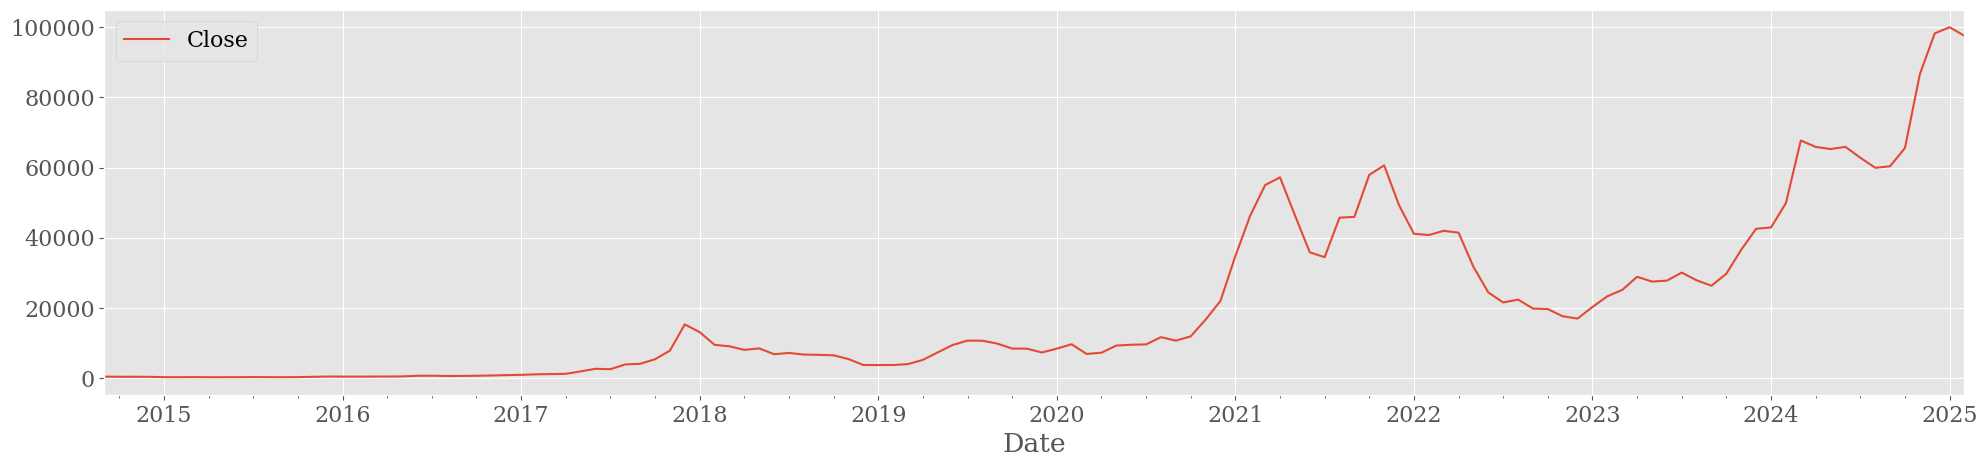

In [11]:
df_monthly = df.set_index("Date").resample("ME")[["Close"]].mean()
df_monthly.plot()

In [12]:
df_monthly

,Close
Date,
2014-09-30,407.182428
2014-10-31,364.148873
2014-11-30,366.099799
2014-12-31,341.267871
2015-01-31,248.782547
...,...
2024-10-31,65577.264491
2024-11-30,86570.707812
2024-12-31,98232.948589


<Figure size 2400x1000 with 0 Axes>

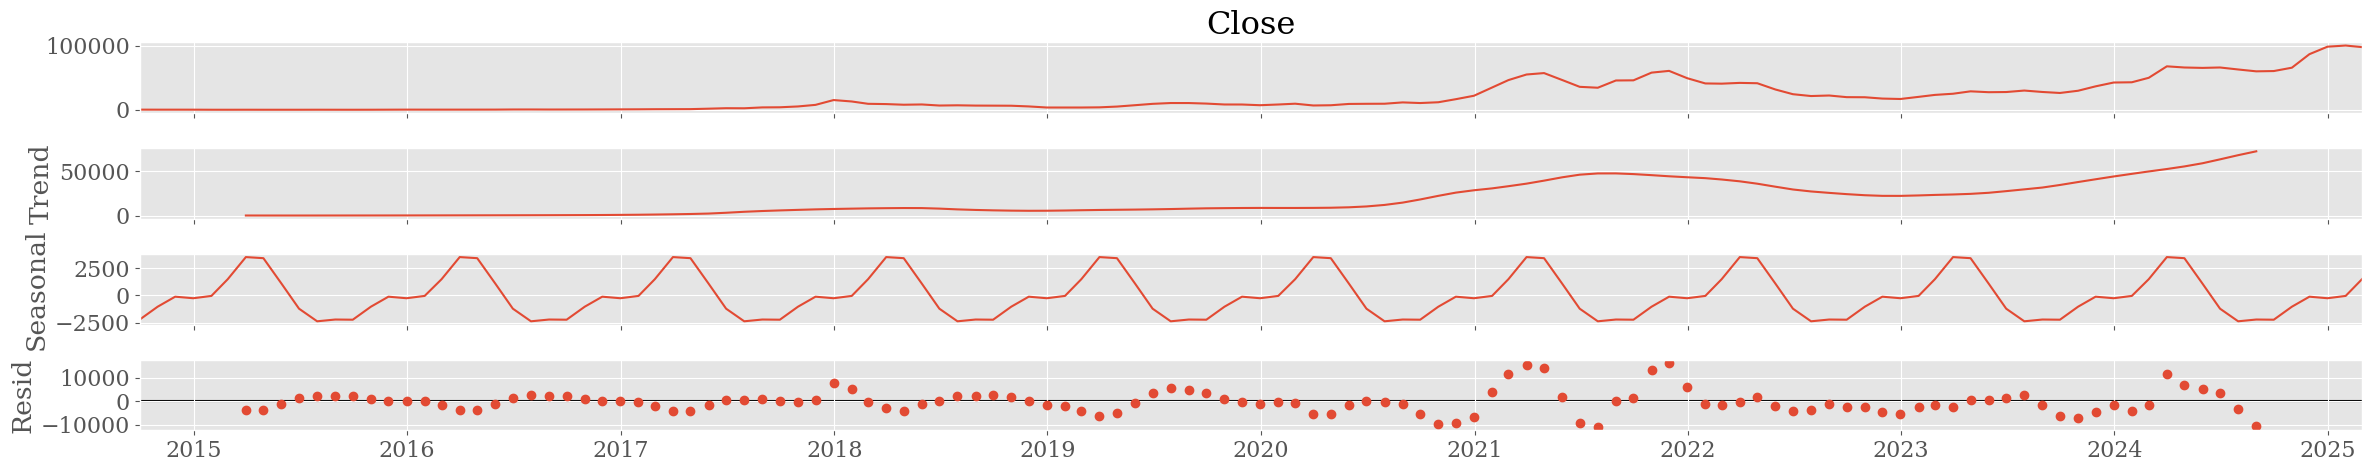

In [13]:
plt.figure(figsize=[24, 10])
sm.tsa.seasonal_decompose(df_monthly["Close"]).plot();
# print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price)[1])

In [14]:
adf = sm.tsa.stattools.adfuller(df_monthly.Close)[1]
stationary = bool(adf < .05)

print(f"Monthly {ticker} Stationary: {stationary}")
print(f"""Augmented Dickey Fuller (ADF) = {adf:.3}""")

Monthly BTC-USD Stationary: False
Augmented Dickey Fuller (ADF) = 0.982


# StatsModels

In [15]:
from statsforecast import StatsForecast
from statsforecast.models import AutoETS

os.environ["NIXTLA_ID_AS_COL"] = "1"

In [16]:
freq = "D"
freq = "ME"
freq = "W-SUN"
label = "Close"

dffit = df.rename(columns={"Ticker": "unique_id", "Date": "ds", label: "y"})[["unique_id", "ds", "y"]]
dffit = dffit.groupby(["unique_id", pd.Grouper(key="ds", freq=freq)])[["y"]].mean().reset_index()
# dffit.plot(x="ds", y="y", figsize=(24, 5))

<Axes: xlabel='ds'>

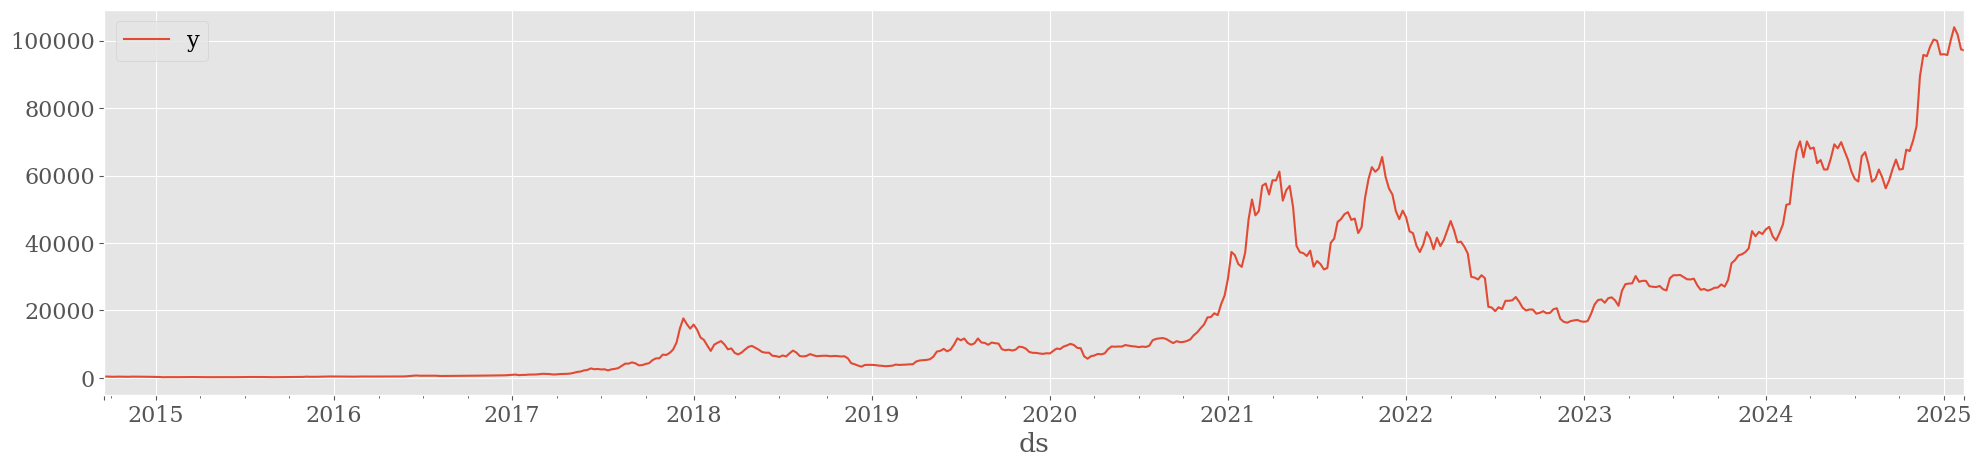

In [17]:
dffit = dffit
dffit.plot(x="ds", y="y", figsize=(24, 5))

In [18]:
MODEL_LIST = [
    AutoETS(season_length=12),
    # AutoARIMA(season_length=12),
]
sf = StatsForecast(models=MODEL_LIST, freq=freq)
sf.fit(dffit)
fcast = sf.forecast(12, dffit)

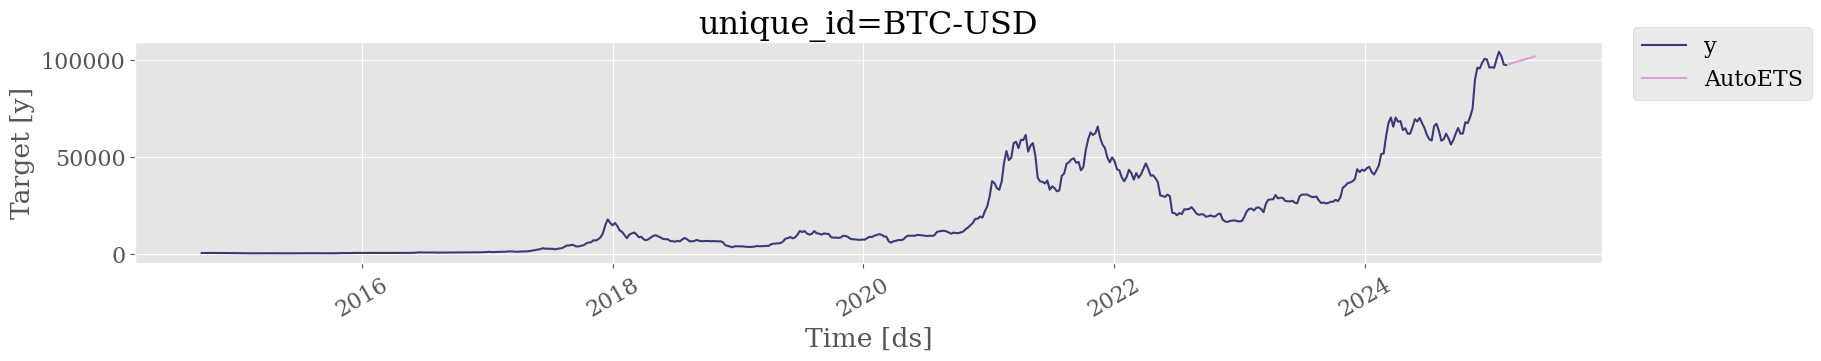

In [19]:
sf.plot(dffit, fcast)

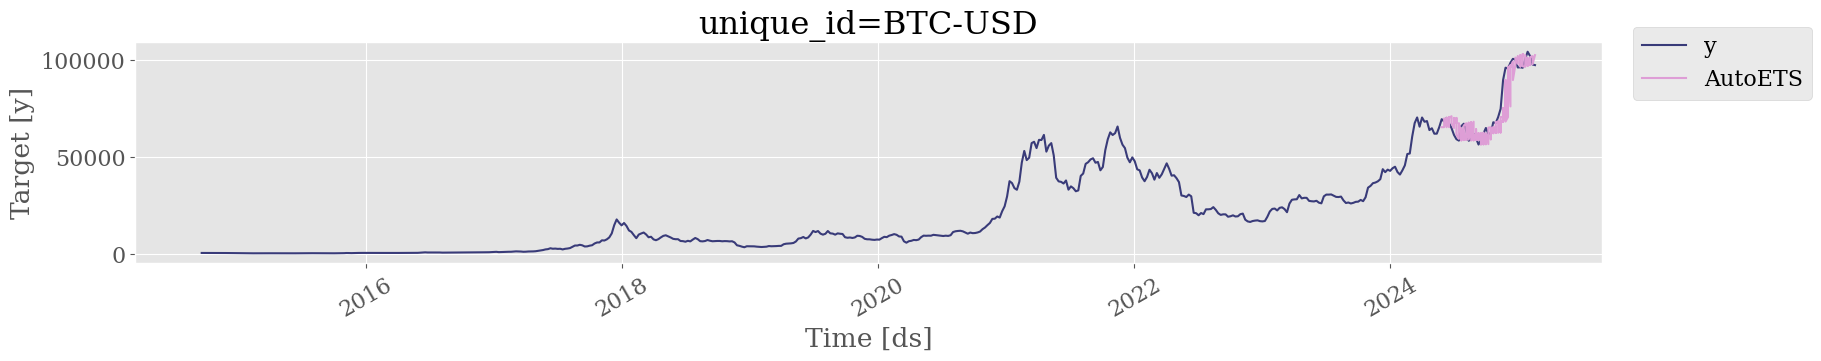

In [20]:
df_cv = sf.cross_validation(h=4, n_windows=36, df=dffit)
sf.plot(dffit, df_cv.drop(["y"], axis="columns"), models=[str(m) for m in sf.models])

In [17]:
dp = DeterministicProcess(index=df["Date"], order=1, drop=True)
trend_features = dp.in_sample()

In [22]:
df

,Ticker,Date,Open,High,Low,Close,Volume,lag1,rolling_mean_7
0,BTC-USD,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,NaN,NaN
1,BTC-USD,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,457.334015,NaN
2,BTC-USD,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,424.440002,NaN
3,BTC-USD,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,394.795990,NaN
4,BTC-USD,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,408.903992,NaN
...,...,...,...,...,...,...,...,...,...
3800,BTC-USD,2025-02-11,97438.132812,98492.898438,94875.039062,95747.429688,37488783272,97437.554688,96557.908482
3801,BTC-USD,2025-02-12,95745.695312,98151.023438,94101.203125,97885.859375,49340445530,95747.429688,96739.396205
3802,BTC-USD,2025-02-13,97888.750000,98111.085938,95269.710938,96623.867188,37147280860,97885.859375,96743.763393
3803,BTC-USD,2025-02-14,96623.367188,98819.468750,96342.804688,97508.968750,32697987277,96623.867188,96883.746652


# MLForecast

In [113]:
import pandas as pd
from typing import Tuple
from mlforecast import MLForecast
from lightgbm import LGBMRegressor
from statsmodels.tsa.deterministic import DeterministicProcess
from window_ops.rolling import rolling_mean
from sktime.forecasting.model_selection import temporal_train_test_split

def prepare_forecast_data(df: pd.DataFrame, test_size: int = 90, label: str = "y", time_col: str = "ds"):
    """Loads OHLCV data and prepares it for forecasting."""
    # Add lag features
    df["lag1"] = df[label].shift(1)
    df["rolling_mean_7"] = rolling_mean(df[label].values, 7)
    
    # Add deterministic trend components
    dp = DeterministicProcess(index=df[time_col], order=1, drop=True)
    trend_features = dp.in_sample()
    
    # df = df.merge(trend_features, left_index=True, right_index=True)
    df = df.merge(trend_features, on=[time_col], how="left")
    
    # Train/test split
    df_train, df_test = temporal_train_test_split(df, test_size=test_size)
    return df_train, df_test

# def fit_predict_lgb(df: pd.DataFrame, horizon: int) -> Tuple[pd.DataFrame, MLForecast]:
#     """Trains MLForecast model using Bitcoin issuance as an exogenous feature."""
#     df_train, df_test = prepare_forecast_data(df)

#     fcst = MLForecast(
#         models=[LGBMRegressor()],
#         freq="D",
#         lags=[1, 7, 30],
#         lag_transforms={"Close": [(rolling_mean, 7)]},
#         date_features=["year", "month", "dayofweek"],
#     )

    
#     fcst.fit(df_train, y="Close", X=df_train[["issuance"]])
#     forecast = fcst.predict(horizon, X=df_test[["issuance"]])
#     return forecast, fcst

# if __name__ == "__main__":
#     train_forecast_model()
# forecast, fcst = fit_predict_lgb(df, horizon=90)

In [105]:
# df_train, df_test = prepare_forecast_data(df)
# fcst = MLForecast(
#     models=[LGBMRegressor()],
#     freq="D",
#     lags=[1, 7, 30],
#     lag_transforms={"Close": [(rolling_mean, 7)]},
#     date_features=["year", "month", "dayofweek"],
# )


# fcst.fit(df_train, y="Close", X=df_train[["issuance"]])
# # forecast = fcst.predict(horizon, X=df_test[["issuance"]])


In [126]:
horizon = 365

label = "Close"
dffit = df.rename(columns={"Ticker": "unique_id", "Date": "ds", label: "y"})
df_train, df_test = prepare_forecast_data(dffit, test_size=horizon)

df_train

,unique_id,ds,Open,High,Low,y,Volume,issuance,lag1,rolling_mean_7,trend
0,BTC-USD,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,7200.0,NaN,NaN,1.0
1,BTC-USD,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,7200.0,457.334015,NaN,2.0
2,BTC-USD,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,7200.0,424.440002,NaN,3.0
3,BTC-USD,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,7200.0,394.795990,NaN,4.0
4,BTC-USD,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,7200.0,408.903992,NaN,5.0
...,...,...,...,...,...,...,...,...,...,...,...
3441,BTC-USD,2024-02-15,51836.785156,52820.066406,51371.628906,51938.554688,38564360533,1800.0,51826.695312,49525.472656,3440.0
3442,BTC-USD,2024-02-16,51937.726562,52537.968750,51641.367188,52160.203125,28180567298,1800.0,51938.554688,50241.616071,3441.0
3443,BTC-USD,2024-02-17,52161.675781,52191.914062,50669.667969,51662.996094,20009091006,1800.0,52160.203125,50797.575893,3442.0
3444,BTC-USD,2024-02-18,51661.968750,52356.964844,51233.707031,52122.546875,17595377311,1800.0,51662.996094,51344.522879,3443.0


In [146]:
static_features = []
external_features = ["issuance"]
df_train = df_train[["unique_id", "ds", "y"] + static_features + external_features]
df_test = df_test[["unique_id", "ds", "y"] + static_features + external_features]

X_train, y_train = df_train.drop("y", axis=1), df_train["y"]
X_test, y_test = df_test.drop("y", axis=1), df_test["y"]

In [155]:
columns = ["unique_id", "ds", "y"] + static_features + external_features

In [150]:
lgb_params = dict(
    force_col_wise=True,
    eval_metric="rmse",
    early_stopping_rounds=50,
    eval_set=[(X_train, y_train), (X_test, y_test)],
)

fcst = MLForecast(
    models=[LGBMRegressor(**lgb_params)],
    freq="D",
    lags=[1, 7, 28],
    lag_transforms = {
        7:  [(rolling_mean, 7), (rolling_mean, 28)],
        28: [(rolling_mean, 7), (rolling_mean, 28)],
    },
    date_features=['year', 'month', 'day', 'dayofweek', 'quarter', 'week'],
    num_threads=4,
)

fcst.fit(df_train, target_col="y",
         static_features=static_features,
        )
forecast = fcst.predict(horizon, X_df=df_test)

[LightGBM] [Warning] issuance is set=, issuance= will be ignored. Current value: issuance=
[LightGBM] [Warning] 3807 is set=, 3807= will be ignored. Current value: 3807=
[LightGBM] [Warning] 1800.0 is set=, 1800.0= will be ignored. Current value: 1800.0=
[LightGBM] [Warning] 1800.0 is set=, 1800.0= will be ignored. Current value: 1800.0=
[LightGBM] [Warning] 1800.0 is set=, 1800.0= will be ignored. Current value: 1800.0=
[LightGBM] [Warning] 1800.0 is set=, 1800.0= will be ignored. Current value: 1800.0=
[LightGBM] [Warning] 1800.0 is set=, 1800.0= will be ignored. Current value: 1800.0=
[LightGBM] [Warning] 1800.0 is set=, 1800.0= will be ignored. Current value: 1800.0=
[LightGBM] [Warning] 1800.0 is set=, 1800.0= will be ignored. Current value: 1800.0=
[LightGBM] [Warning] 1800.0 is set=, 1800.0= will be ignored. Current value: 1800.0=
[LightGBM] [Warning] 1800.0 is set=, 1800.0= will be ignored. Current value: 1800.0=
[LightGBM] [Warning] Name: is set=, Name:= will be ignored. Curre

ValueError: For early stopping, at least one dataset and eval metric is required for evaluation

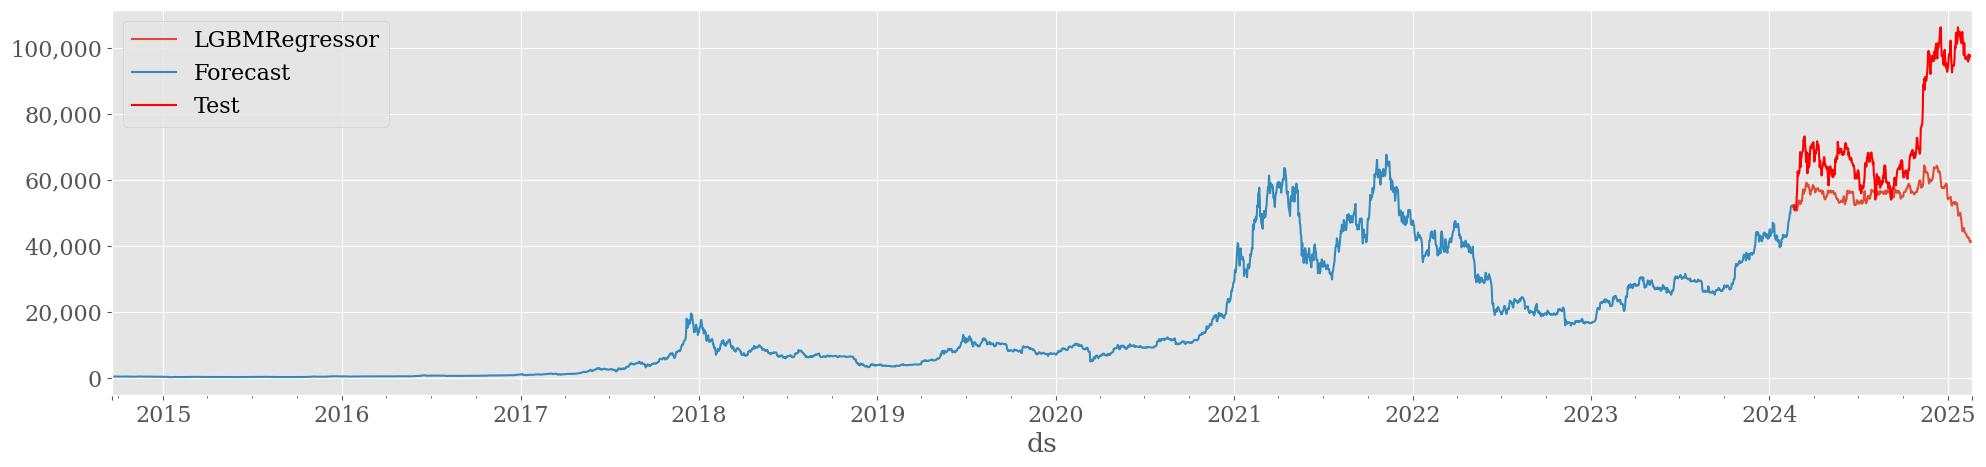

In [151]:
model_names = list(fcst.models.keys())
fig, ax = plt.subplots()
forecast.set_index("ds")[model_names].plot(ax=ax, label="Train")
df_train.set_index("ds")["y"].plot(ax=ax, label="Forecast")
df_test.set_index("ds")["y"].plot(ax=ax, color="red", label="Test")
plt.legend()
format_yaxis_thousands(ax)

In [156]:
dffeats = fcst.preprocess(dffit[columns], static_features=static_features)
df_train, df_test = prepare_forecast_data(dffeats, test_size=horizon)
df_train

,unique_id,ds,y,issuance,lag1,lag7,lag28,rolling_mean_lag7_window_size7,rolling_mean_lag7_window_size28,rolling_mean_lag28_window_size7,rolling_mean_lag28_window_size28,year,month,day,dayofweek,quarter,week,rolling_mean_7,trend
0,BTC-USD,2014-11-11,367.695007,7200.0,NaN,330.492004,400.869995,332.700570,363.016465,373.094291,383.787679,2014,11,11,1,4,46,NaN,1.0
1,BTC-USD,2014-11-12,423.561005,7200.0,367.695007,339.485992,394.773010,333.256997,362.535965,379.070435,381.553358,2014,11,12,2,4,46,NaN,2.0
2,BTC-USD,2014-11-13,420.734985,7200.0,423.561005,349.290009,382.556000,333.826285,361.973965,381.574720,380.057501,2014,11,13,3,4,46,NaN,3.0
3,BTC-USD,2014-11-14,397.817993,7200.0,420.734985,342.415009,383.757996,334.411142,361.290144,384.745575,379.663286,2014,11,14,4,4,46,NaN,4.0
4,BTC-USD,2014-11-15,376.132996,7200.0,397.817993,345.488007,391.441986,337.231001,360.689751,388.908857,379.039643,2014,11,15,5,4,46,NaN,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3386,BTC-USD,2024-02-15,51938.554688,1800.0,51826.695312,45301.566406,41262.058594,43446.402902,42262.628488,42451.920759,43607.061942,2024,2,15,3,1,7,49525.472656,3385.0
3387,BTC-USD,2024-02-16,52160.203125,1800.0,51938.554688,47147.199219,41618.406250,44012.308594,42415.986747,42275.526228,43522.079939,2024,2,16,4,1,7,50241.616071,3386.0
3388,BTC-USD,2024-02-17,51662.996094,1800.0,52160.203125,47771.277344,41665.585938,44695.026786,42592.018694,42107.412388,43448.010045,2024,2,17,5,1,7,50797.575893,3387.0
3389,BTC-USD,2024-02-18,52122.546875,1800.0,51662.996094,48293.917969,41545.785156,45510.789062,42824.077567,42071.628906,43395.498186,2024,2,18,6,1,7,51344.522879,3388.0


In [179]:
X = df_train.drop("y", axis=1)
y = df_train["y"]

X_val = df_test.drop("y", axis=1)
y_val = df_test["y"]

In [180]:
train_days = X["ds"]
test_days = X_val["ds"]

X = X.select_dtypes(include=["int", "float"])
X_val = X_val.select_dtypes(include=["int", "float"])

In [202]:
import lightgbm as lgb
model = lgb.LGBMRegressor(n_estimators=1_000, learning_rate=.001, verbosity=-1, early_stopping_rounds=50, metric="rmse")
model.fit(
    X,
    y,
    eval_set=[(X, y), (X_val, y_val)],
    # categorical_feature=['dayofweek'],
    callbacks=[lgb.log_evaluation(50)],
);

[50]	training's rmse: 15693.6	valid_1's rmse: 57923.6
[100]	training's rmse: 14930.3	valid_1's rmse: 55824.2
[150]	training's rmse: 14204.3	valid_1's rmse: 53837.5
[200]	training's rmse: 13513.9	valid_1's rmse: 51952.1
[250]	training's rmse: 12857.2	valid_1's rmse: 50163.9
[300]	training's rmse: 12232.7	valid_1's rmse: 48467.2
[350]	training's rmse: 11638.7	valid_1's rmse: 46858.2
[400]	training's rmse: 11073.8	valid_1's rmse: 45332.8
[450]	training's rmse: 10536.6	valid_1's rmse: 43887.1
[500]	training's rmse: 10025.8	valid_1's rmse: 42517.6
[550]	training's rmse: 9539.94	valid_1's rmse: 41219.8
[600]	training's rmse: 9077.95	valid_1's rmse: 39989.9
[650]	training's rmse: 8638.65	valid_1's rmse: 38820.6
[700]	training's rmse: 8220.91	valid_1's rmse: 37713.6
[750]	training's rmse: 7823.7	valid_1's rmse: 36666.2
[800]	training's rmse: 7446.01	valid_1's rmse: 35678.4
[850]	training's rmse: 7086.91	valid_1's rmse: 34744
[900]	training's rmse: 6745.47	valid_1's rmse: 33872.5
[950]	training

In [203]:
preds = model.predict(X_val)

In [204]:
y_fit = pd.Series(dict(zip(train_days, y_train)))
y_pred = pd.Series(dict(zip(test_days, preds)))
y_test = pd.Series(dict(zip(test_days, y_test)))

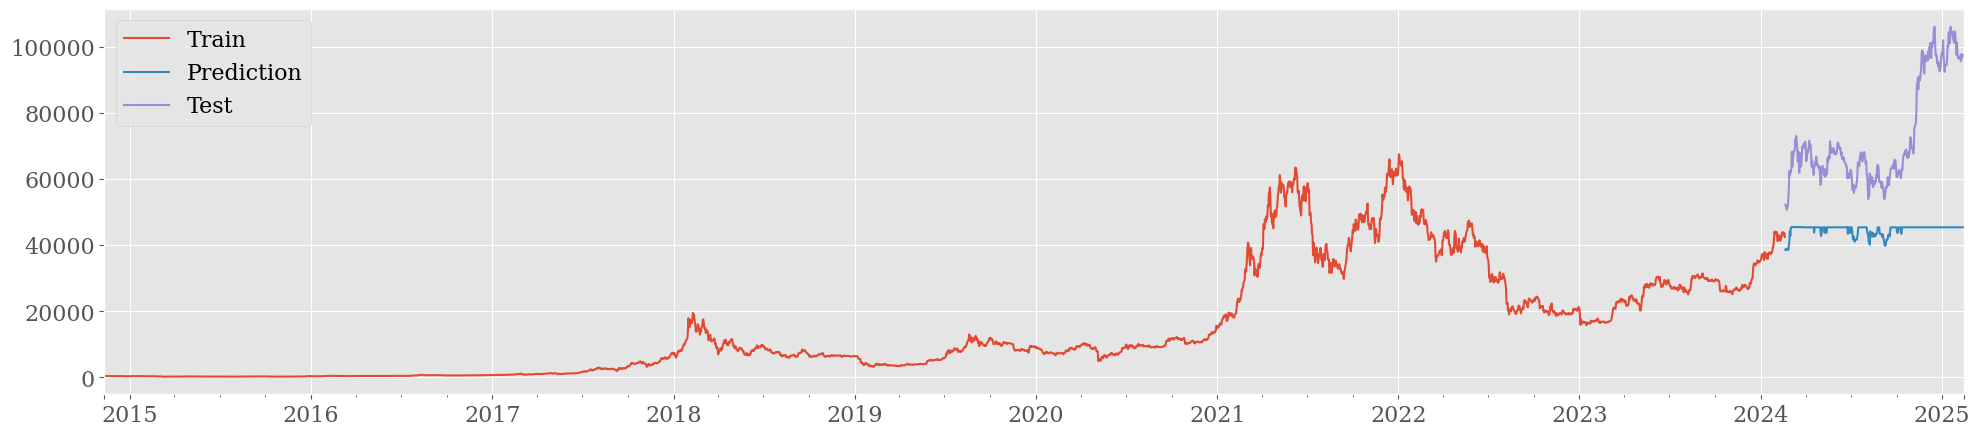

In [205]:
fig, ax = plt.subplots()

y_fit.plot(ax=ax, label="Train")
y_pred.plot(ax=ax, label="Prediction")
y_test.plot(ax=ax, label="Test")
plt.legend()
plt.show()

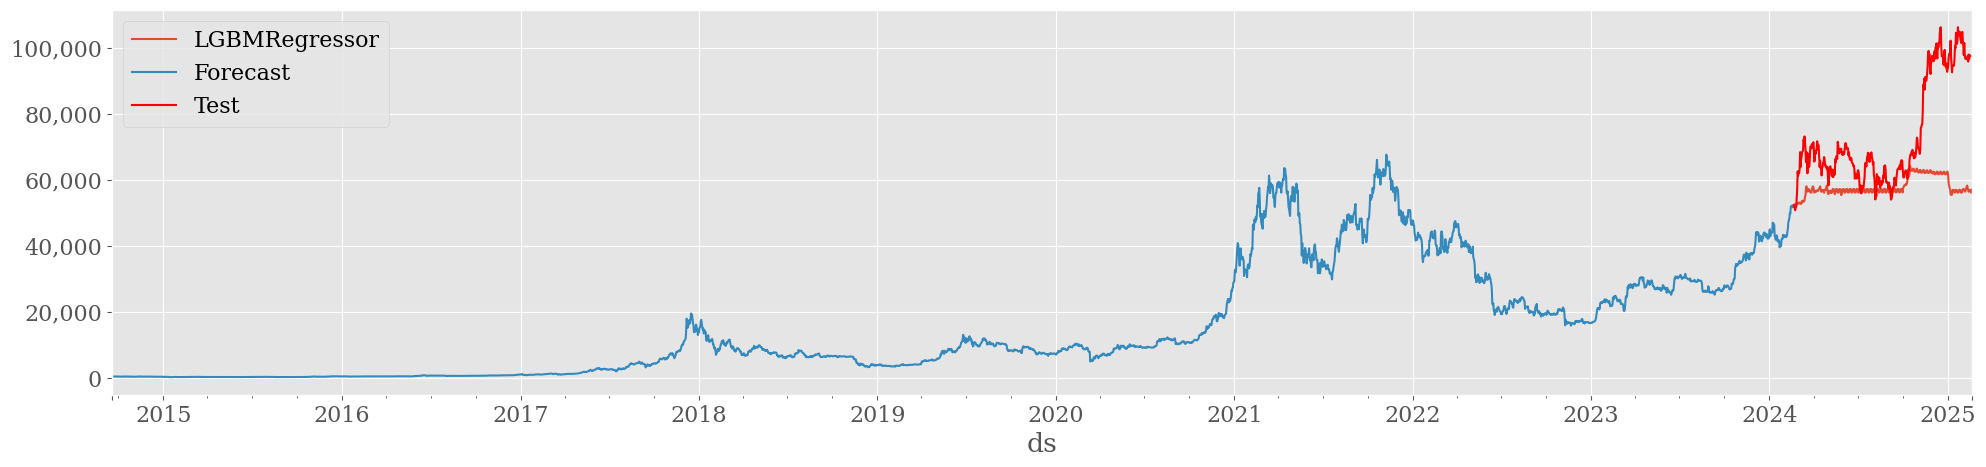

In [124]:
model_names = list(fcst.models.keys())
fig, ax = plt.subplots()
forecast.set_index("ds")[model_names].plot(ax=ax, label="Train")
df_train.set_index("ds")["y"].plot(ax=ax, label="Forecast")
df_test.set_index("ds")["y"].plot(ax=ax, color="red", label="Test")
plt.legend()
format_yaxis_thousands(ax)

In [125]:
df_train

,unique_id,ds,y
0,BTC-USD,2014-09-17,457.334015
1,BTC-USD,2014-09-18,424.440002
2,BTC-USD,2014-09-19,394.795990
3,BTC-USD,2014-09-20,408.903992
4,BTC-USD,2014-09-21,398.821014
...,...,...,...
3441,BTC-USD,2024-02-15,51938.554688
3442,BTC-USD,2024-02-16,52160.203125
3443,BTC-USD,2024-02-17,51662.996094
3444,BTC-USD,2024-02-18,52122.546875
